# Implementation REINFORCE Algorithm in CartPole-v1

## Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [ ]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [ ]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [ ]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

## Explore the environment

Initialize CartPole Environment and Display State & Action Spaces

In [ ]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


Define a Random Policy for Action Selection  

In [ ]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [ ]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

## Agent with REINFORCE Algorithm in CartPole-v1


### Policy Network Definition

In [ ]:
# Policy Network
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

### Hyperparameters

In [ ]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
episodes = 2000

### Environment

In [ ]:
# Environment setup
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

### Initialization

In [ ]:
# Initialize policy and optimizer
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Choose action

In [ ]:
# Function to choose action based on policy
def choose_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

### Training

In [ ]:
# Training loop
sum_rewards = []
for episode in range(episodes):
    state = env.reset()
    rewards = []
    log_probs = []

    while True:
        action, log_prob = choose_action(state)
        next_state, reward, done, _ = env.step(action)

        rewards.append(reward)
        log_probs.append(log_prob)

        state = next_state

        if done:
            break

    # Calculate discounted rewards
    discounted_rewards = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)

    # Normalize discounted rewards
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    # Calculate policy loss
    policy_loss = []
    for log_prob, reward in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.cat(policy_loss).sum()

    # Update policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # Store sum of rewards
    sum_rewards.append(sum(rewards))

    # Print episode information
    if episode % 50 == 0:
        print(f"Episode {episode}, Sum of rewards: {sum(rewards)}")

Episode 0, Sum of rewards: 31.0
Episode 50, Sum of rewards: 17.0
Episode 100, Sum of rewards: 39.0
Episode 150, Sum of rewards: 66.0
Episode 200, Sum of rewards: 37.0
Episode 250, Sum of rewards: 160.0
Episode 300, Sum of rewards: 390.0
Episode 350, Sum of rewards: 336.0
Episode 400, Sum of rewards: 161.0
Episode 450, Sum of rewards: 498.0
Episode 500, Sum of rewards: 500.0
Episode 550, Sum of rewards: 500.0
Episode 600, Sum of rewards: 125.0
Episode 650, Sum of rewards: 500.0
Episode 700, Sum of rewards: 500.0
Episode 750, Sum of rewards: 500.0
Episode 800, Sum of rewards: 458.0
Episode 850, Sum of rewards: 500.0
Episode 900, Sum of rewards: 500.0
Episode 950, Sum of rewards: 500.0
Episode 1000, Sum of rewards: 500.0
Episode 1050, Sum of rewards: 500.0
Episode 1100, Sum of rewards: 500.0
Episode 1150, Sum of rewards: 500.0
Episode 1200, Sum of rewards: 500.0
Episode 1250, Sum of rewards: 500.0
Episode 1300, Sum of rewards: 500.0
Episode 1350, Sum of rewards: 500.0
Episode 1400, Sum of

## Plot and Comparing Results

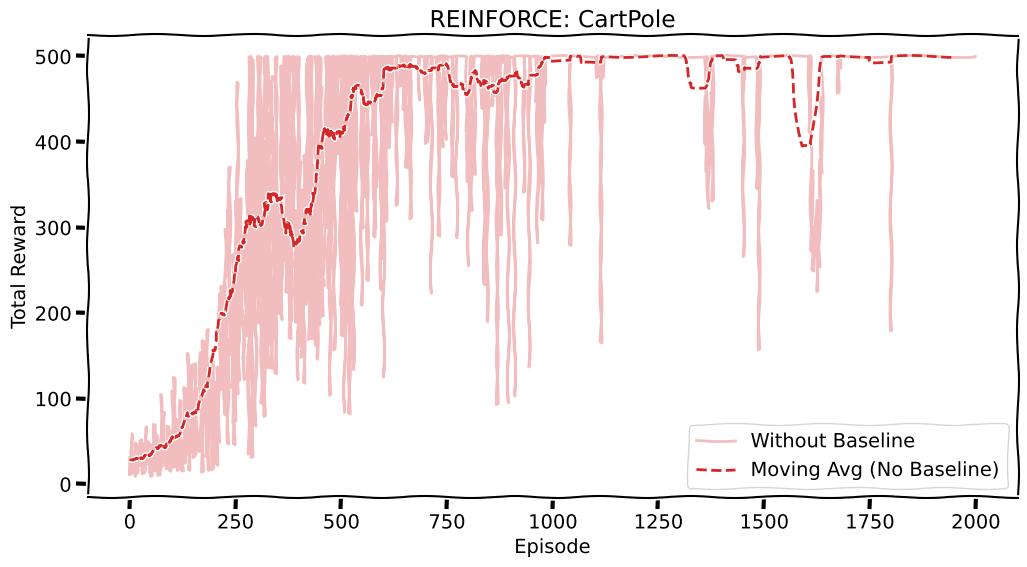

In [ ]:
# Plotting Results
window_size = 50  # Moving average window size

# Moving average calculation
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(sum_rewards, label="Rewards", alpha=0.3, color='tab:red')

# Plotting moving averages
plt.plot(moving_average(sum_rewards, window_size), label="Moving Avg", linestyle='--', color='tab:red')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: CartPole")
plt.show()

In [ ]:
mean_reward, std_reward = np.mean(sum_rewards), np.std(sum_rewards)
print(f"Mean Reward = {mean_reward:.2f} +/- {std_reward:.4f}")

No Baseline: mean_reward = 410.70 +/- 156.7116


## Simulation

In [ ]:
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy.to(DEVICE), "Video_CartPole")

# REINFORCE Algorith VS Genetic Algorithm (GA)

## Setup

All required packages are pre-installed if using Google Colab.

Import the following libraries.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Environment

### GridWorld Class Definition (10 Points)

In [2]:
# Grid World Parameters
GRID_SIZE = 5
PENALTIES = {(1, 1): -10, (1, 3): -10, (2, 0): -10, (3, 1): -10, (3, 3): -10, (0, 4): -10}
GOAL = (4, 4)
GOAL_REWARD = 100
STEP_PENALTY = -1
BOUNDARY_PENALTY = -5
ACTIONS = ['up', 'down', 'left', 'right']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

### GridWorld Environmnet Definition

In [3]:
class GridWorld:
    def step(self, state, action):
        x, y = state
        new_x, new_y = x, y

        if action == 'right':
            new_x = min(x + 1, GRID_SIZE - 1)
        elif action == 'left':
            new_x = max(x - 1, 0)
        elif action == 'up':
            new_y = min(y + 1, GRID_SIZE - 1)
        elif action == 'down':
            new_y = max(y - 1, 0)

        reward = STEP_PENALTY
        if (new_x, new_y) == (x, y):
            reward += BOUNDARY_PENALTY
        if (new_x, new_y) in PENALTIES:
            reward += PENALTIES[(new_x, new_y)]
        if (new_x, new_y) == GOAL:
            reward += GOAL_REWARD

        return (new_x, new_y), reward

### Initialize the Grid World

In [4]:
grid_world = GridWorld()

### Plot Empty Grid World

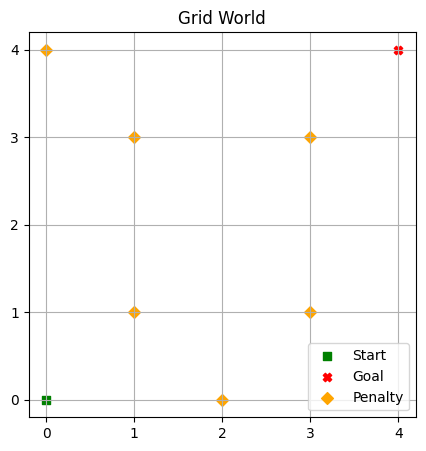

In [98]:
plt.figure(figsize=(5, 5))
plt.scatter(0, 0, c='green', marker='s', label='Start')
plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
for i, (px, py) in enumerate(PENALTIES):
    if i == 0:
        plt.scatter(px, py, c='orange', marker='D', label='Penalty')
    else:
        plt.scatter(px, py, c='orange', marker='D')
plt.xticks(range(GRID_SIZE))
plt.yticks(range(GRID_SIZE))
plt.title("Grid World")
plt.legend()
plt.grid(True)
plt.show()

## REINFORCE Algorithm

### Policy Network Definition

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=4, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        return torch.log_softmax(self.fc2(x), dim=-1)


### REINFORCE Agent Implementation

In [56]:
class ReinforceAgent:
    def __init__(self, lr=0.005, gamma=0.99):
        self.policy_net = PolicyNetwork()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma

    def train(self, episodes=8000, epsilon=0.99, epsilon_decay=0.999, min_epsilon=0.1):
        for episode in range(episodes):
            state = (0, 0)
            trajectory, rewards = [], []
            STOP = 0

            while state != GOAL and STOP <= 100:
                state_tensor = torch.tensor(state, dtype=torch.float32)
                log_action_probs = self.policy_net(state_tensor).detach().numpy()
                action_probs = np.exp(log_action_probs)

                action = np.random.choice(ACTIONS) if random.random() < epsilon else ACTIONS[np.argmax(action_probs)]
                new_state, reward = grid_world.step(state, action)

                trajectory.append((state, action, reward))
                rewards.append(reward)
                state = new_state
                STOP += 1

            returns, G = [], 0
            for r in reversed(rewards):
                G = r + self.gamma * G
                returns.insert(0, G)

            returns = torch.tensor(returns, dtype=torch.float32)
            baseline = returns.mean()
            returns -= baseline

            loss = 0
            for (state, action, _), G in zip(trajectory, returns):
                state_tensor = torch.tensor(state, dtype=torch.float32)
                log_action_probs = self.policy_net(state_tensor)
                loss -= log_action_probs[ACTION_IDX[action]] * G

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epsilon = max(min_epsilon, epsilon * epsilon_decay)

            if episode % 50 == 0:
                print(f"Episode {episode}: Total Reward = {sum(rewards)}, Epsilon = {epsilon:.4f}")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        STOP = 0
        while state != GOAL and STOP <= 100:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            log_action_probs = self.policy_net(state_tensor).detach().numpy()
            action_probs = np.exp(log_action_probs)
            # action = np.random.choice(ACTIONS, p=action_probs / action_probs.sum())
            action = ACTIONS[np.argmax(action_probs)]
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            STOP += 1
        return trajectory, rewards

## Genetic Algorithm


Genetic Algorithms (GAs) are optimization algorithms inspired by **natural selection**. They evolve a population of candidate solutions over multiple generations to find an optimal or near-optimal solution.

#### **1. Population ($P$)**
A **population** consists of multiple candidate solutions (individuals). Each individual represents a **policy or solution** encoded as a chromosome.

$$[
P_t = \{ X_1^t, X_2^t, ..., X_N^t \}
]$$

where:
- $( P_t )$ is the population at generation $( t )$,
- $( X_i^t )$ is the $( i )$-th individual in the population,
- $( N )$ is the population size.

#### **2. Fitness Function ($F$)**
Each individual is evaluated using a **fitness function**, which measures how good a solution is.

$$[
F(X_i) = \text{reward or performance score of } X_i
]$$

#### **3. Selection**
The best individuals are selected based on their fitness scores to produce the next generation. Common methods include:
- **Roulette Wheel Selection** (Probability proportional to fitness)
- **Tournament Selection** (Select the best out of a subset)

#### **4. Crossover (Recombination)**
Two parents **combine genetic information** to create offspring. A common method is **single-point crossover**, where a random crossover point is chosen.

$$
\begin{aligned}
\text{Parent 1} &= (A_1, A_2, | A_3, A_4, A_5) \\
\text{Parent 2} &= (B_1, B_2, | B_3, B_4, B_5) \\
\text{Offspring 1} &= (A_1, A_2, | B_3, B_4, B_5) \\
\text{Offspring 2} &= (B_1, B_2, | A_3, A_4, A_5)
\end{aligned}
$$

#### **5. Mutation**
Mutation introduces small **random changes** in individuals to maintain diversity and avoid local optima. If $( X_i )$ is an individual, a mutation function $( M )$ alters some genes:

$$[
X_i' = M(X_i)
]$$

For example, if an individual’s policy is `['up', 'right', 'down']`, mutation might randomly change `right` to `left`.

#### **6. Generations & Evolution**
The new population is formed after selection, crossover, and mutation. The process repeats for **multiple generations** until a stopping criterion is met (e.g., max generations or convergence).

$$[
P_{t+1} = \text{next\_generation}(P_t)
]$$



### Genetic Algorithm Implementation

In [57]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, policy_network, generations=100, device='cpu'):
        self.device = device
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.policy_network = policy_network.to(self.device)  # Move the model to GPU
        self.population = [self._initialize_individual() for _ in range(population_size)]

    def _initialize_individual(self):
        # Initialize an individual by setting random weights for the policy network
        individual = {}
        for name, param in self.policy_network.named_parameters():
            individual[name] = torch.randn_like(param).to(self.device)  # Move individual weights to GPU
        return individual

    def _evaluate_individual(self, individual):
        # Simulate the evaluation (for example, run a few episodes in GridWorld environment)
        self._apply_individual_weights(individual)
        state = (0, 0)
        STOP = 0
        trajectory, rewards = [], []
        while state != GOAL and STOP <= 50:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            new_state, reward = grid_world.step(state, action)
            trajectory.append((state, action, reward))
            rewards.append(reward)
            state = new_state
            STOP += 1
        return sum(rewards)

    def _apply_individual_weights(self, individual):
        # Apply the weights of an individual to the policy network
        for name, param in individual.items():
            self.policy_network.state_dict()[name].copy_(param)

    def _select_parents(self):
        # Select two individuals based on fitness (higher reward is better)
        scores = [(ind, self._evaluate_individual(ind)) for ind in self.population]
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        parent1 = sorted_scores[0][0]
        parent2 = sorted_scores[1][0]
        return parent1, parent2

    def _crossover(self, parent1, parent2):
        # Perform crossover to combine the genetic material of two parents
        child = {}
        for name in parent1.keys():
            if random.random() < self.crossover_rate:
                child[name] = parent1[name]
            else:
                child[name] = parent2[name]
        return child

    def _mutate(self, individual):
        # Perform mutation (randomly modify the weights)
        for name, param in individual.items():
            if random.random() < self.mutation_rate:
                individual[name] = torch.randn_like(param).to(self.device)  # Ensure mutated weight is on GPU
        return individual

    def run(self):
        for generation in range(self.generations):
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self._select_parents()
                child1 = self._crossover(parent1, parent2)
                child2 = self._crossover(parent2, parent1)
                new_population.append(self._mutate(child1))
                new_population.append(self._mutate(child2))
            self.population = new_population
            print(f"Generation {generation + 1} completed")

    def get_optimal_trajectory(self):
        state = (0, 0)
        trajectory = [state]
        rewards = 0
        STOP = 0
        while state != GOAL and STOP <= 100:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)  # Move state to GPU
            log_action_probs = self.policy_network(state_tensor)
            action_probs = torch.exp(log_action_probs)
            action_idx = torch.argmax(action_probs).item()  # Get action with highest probability
            action = ACTIONS[action_idx]  # Map action index back to action
            state, reward = grid_world.step(state, action)
            rewards += reward
            trajectory.append(state)
            STOP += 1
        return trajectory, rewards

## Running & Comparing Agents

In [72]:
# Train REINFORCE agent

LEARNING_RATE = 0.005
GAMMA = 0.99

reinforce_agent = ReinforceAgent(lr = LEARNING_RATE, gamma = GAMMA)
reinforce_agent.train(episodes=2500, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.1)

Episode 0: Total Reward = -516, Epsilon = 0.9990
Episode 50: Total Reward = 8, Epsilon = 0.9503
Episode 100: Total Reward = -120, Epsilon = 0.9039
Episode 150: Total Reward = 28, Epsilon = 0.8598
Episode 200: Total Reward = -368, Epsilon = 0.8178
Episode 250: Total Reward = -88, Epsilon = 0.7779
Episode 300: Total Reward = 62, Epsilon = 0.7400
Episode 350: Total Reward = -304, Epsilon = 0.7039
Episode 400: Total Reward = -64, Epsilon = 0.6695
Episode 450: Total Reward = 76, Epsilon = 0.6368
Episode 500: Total Reward = 58, Epsilon = 0.6058
Episode 550: Total Reward = 46, Epsilon = 0.5762
Episode 600: Total Reward = -166, Epsilon = 0.5481
Episode 650: Total Reward = -270, Epsilon = 0.5214
Episode 700: Total Reward = -226, Epsilon = 0.4959
Episode 750: Total Reward = 64, Epsilon = 0.4717
Episode 800: Total Reward = 66, Epsilon = 0.4487
Episode 850: Total Reward = -224, Epsilon = 0.4268
Episode 900: Total Reward = 60, Epsilon = 0.4060
Episode 950: Total Reward = -116, Epsilon = 0.3862
Epis

In [95]:
# Train Genetic Algorithm agent

POPULATION_SIZE = 15
GENERATIONS = 50
MUTATION_RATE = 0.15
CROSSOVER_RATE = 0.7

policy_network = PolicyNetwork()
genetic_agent = GeneticAlgorithm(generations=GENERATIONS, population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, crossover_rate=CROSSOVER_RATE, policy_network=policy_network, device=device)
optimal_genetic_policy = genetic_agent.run()

Generation 1 completed
Generation 2 completed
Generation 3 completed
Generation 4 completed
Generation 5 completed
Generation 6 completed
Generation 7 completed
Generation 8 completed
Generation 9 completed
Generation 10 completed
Generation 11 completed
Generation 12 completed
Generation 13 completed
Generation 14 completed
Generation 15 completed
Generation 16 completed
Generation 17 completed
Generation 18 completed
Generation 19 completed
Generation 20 completed
Generation 21 completed
Generation 22 completed
Generation 23 completed
Generation 24 completed
Generation 25 completed
Generation 26 completed
Generation 27 completed
Generation 28 completed
Generation 29 completed
Generation 30 completed
Generation 31 completed
Generation 32 completed
Generation 33 completed
Generation 34 completed
Generation 35 completed
Generation 36 completed
Generation 37 completed
Generation 38 completed
Generation 39 completed
Generation 40 completed
Generation 41 completed
Generation 42 completed
G

## Visualizing Results

Plots the agent’s trajectory in the Grid World.

In [76]:
def visualize_trajectory(trajectory, title):
    plt.figure(figsize=(5, 5))
    x_vals, y_vals = zip(*trajectory)
    plt.plot(x_vals, y_vals, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.scatter(0, 0, c='green', marker='s', label='Start')
    plt.scatter(GOAL[0], GOAL[1], c='red', marker='X', label='Goal')
    for i, (px, py) in enumerate(PENALTIES):
        if i == 0:
            plt.scatter(px, py, c='orange', marker='D', label='Penalty')
        else:
            plt.scatter(px, py, c='orange', marker='D')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Results

Final Reward (REINFORCE): 82



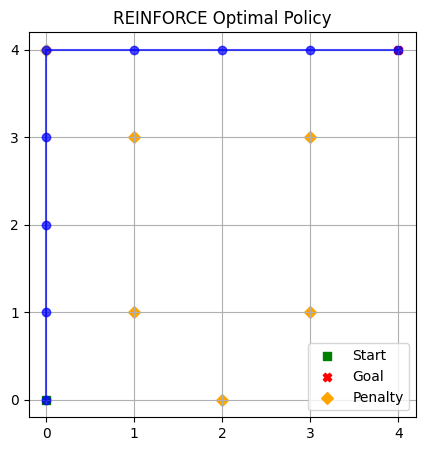


--------------------------------------------------------------------------------------

Final Reward (Genetic Algorithm): 72



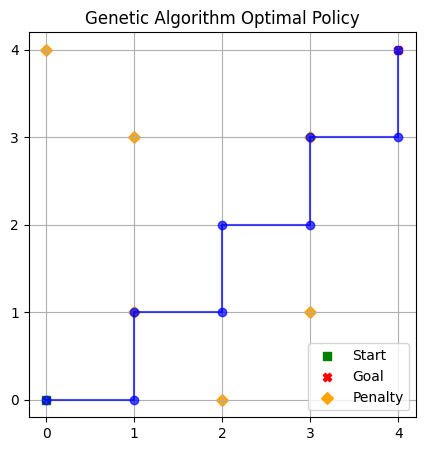

In [97]:
# Results

optimal_reinforce_trajectory, final_reward_reinforce = reinforce_agent.get_optimal_trajectory()
print(f"Final Reward (REINFORCE): {final_reward_reinforce}\n")
visualize_trajectory(optimal_reinforce_trajectory, "REINFORCE Optimal Policy")

print("\n--------------------------------------------------------------------------------------\n")

optimal_genetic_trajectory, final_reward_genetic = genetic_agent.get_optimal_trajectory()
print(f"Final Reward (Genetic Algorithm): {final_reward_genetic}\n")
visualize_trajectory(optimal_genetic_trajectory, "Genetic Algorithm Optimal Policy")